## Introdução

A proposta do problema é de classificação: dadas certas caracterísitcas de um objeto, queremos prever qual é sua classe. Concretamente, propomos um problema de concessão de crédito: dado um usuário de cartão de crédito, determinar se esse usuário irá ou não entrar em default(i.e.,não vai pagar o que deve).

In [1]:
pip install h2o

### Iniciando a execução

A importação das bicliotecas ou pacotes Python estão nas linhas de comando abaixo.

* Pandas para manipulação de dados em formato de Data Frame
* Seaborn para criação de gráficos mais elaborados e com maior qualidade visual
* Numpy é um pacote que suporta arrays e matrizes multidimensionais
* Matplotlib é a biblioteca gráfica de base usada em cojunto com Seaborn
* ipywidgets para interação com Jupyter Notebook
* H2O é uma plataforma de aprendizado de máquina e análise preditiva de código aberto, na memória, distribuída, rápida e escalonável, que permite criar modelos de aprendizado de máquina em big data e fornece fácil produção desses modelos em um ambiente corporativo


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline 
import h2o
from h2o.estimators import H2ORandomForestEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp0wnf5wiy
  JVM stdout: /tmp/tmp0wnf5wiy/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp0wnf5wiy/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.28.1.2
H2O cluster version age:    6 days
H2O cluster name:           H2O_from_python_unknownUser_45el1t
H2O cluster total nodes:    1
H2O cluster free memory:    3 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:       {'http': None, 'https': None}
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python version:             3.6.9 final
--------------------------  ------------------------------------------------------------------

### Leitura do arquivo fonte

Para esse passo é importante ter acesso à Internet.
O arquivo original será descarregado do site:

![default of credit card clients Data Set](https://archive.ics.uci.edu/ml/assets/logo.gif)

[Arquivo Original](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)

In [0]:
dfo = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls', index_col=0,skiprows=[0])

### Transformações

Faremos aqui algumas transformações para deixar mais claro as variáveis envolvidas. Os nomes originais são pouco elucidativos e podem causar confusão quando mostrados em gráficos ou tabelas.

In [0]:
dfo.rename({'PAY_6': 'Payment_Status_Apr', # x6
           'PAY_5': 'Payment_Status_May', 
           'PAY_4': 'Payment_Status_Jun', 
           'PAY_3': 'Payment_Status_Jul', 
           'PAY_2': 'Payment_Status_Aug', 
           'PAY_0': 'Payment_Status_Sep', # x11
           'BILL_AMT6': 'Bill_Apr', 
           'BILL_AMT5': 'Bill_May', 
           'BILL_AMT4': 'Bill_Jun',
           'BILL_AMT3': 'Bill_Jul', 
           'BILL_AMT2': 'Bill_Aug', 
           'BILL_AMT1': 'Bill_Sep',
           'PAY_AMT6': 'Payments_Apr', 
           'PAY_AMT5': 'Payments_May', 
           'PAY_AMT4': 'Payments_Jun',
           'PAY_AMT3': 'Payments_Jul', 
           'PAY_AMT2': 'Payments_Aug', 
           'PAY_AMT1': 'Payments_Sep',
           'default payment next month': 'default'}, 
           axis=1, inplace=True)


Abaixo temos parte dos dados expostos. Observamos que as variáveis *Payment_Status_???* tem valores negativos. 

In [5]:
dfo.head()

LIMIT_BAL  SEX  EDUCATION  ...  Payments_May  Payments_Apr  default
ID                             ...                                     
1       20000    2          2  ...             0             0        1
2      120000    2          2  ...             0          2000        1
3       90000    2          2  ...          1000          5000        0
4       50000    2          2  ...          1069          1000        0
5       50000    1          2  ...           689           679        0

[5 rows x 24 columns]

Presumimos que os valores de -2 a 0 signifiquem o seguinte:

* -2 - Saldo pago integralmente e nenhuma transação neste período (podemos nos referir a esta conta de cartão de crédito como 'inativa' neste período) ou seja, **sem consumo**

* -1 = Saldo pago integralmente, mas a conta possui um saldo positivo no final do período devido a transações recentes pelas quais o pagamento ainda não foi devido

* 0 - O cliente pagou o valor mínimo devido, mas não o saldo total. Ou seja, o cliente pagou o suficiente para que sua conta permanecesse em boas condições, mas revolveu um saldo, - **O uso de crédito rotativo**

* 1 - atraso no pagamento por um mês;
* 2 - atraso no pagamento por dois meses; 
* ...
* 8 - atraso no pagamento por oito meses;
* 9 - atraso no pagamento por nove meses e acima.

Veja as explicações em (inglês): [Minimum Monthly Payment](https://www.investopedia.com/terms/m/minimum-monthly-payment.asp)

As  dimensões da amostra são:
* 30000 observações
* 24 características

In [6]:
dfo.shape

(30000, 24)

**Verificação de dados ausentes**

Veremos que não há dados ausentes. É muito importante porque o tratamento de limpeza deste não é necessário.

In [7]:
total = dfo.isnull().sum().sort_values(ascending = False)
percent = (dfo.isnull().sum()/dfo.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

default  Payments_Apr  SEX  ...  Payments_Jun  Payments_May  LIMIT_BAL
Total        0.0           0.0  0.0  ...           0.0           0.0        0.0
Percent      0.0           0.0  0.0  ...           0.0           0.0        0.0

[2 rows x 24 columns]

**Verificando classes desequilibradas**

Vamos verificar o desequilíbrio dos dados em relação ao valor-alvo, ou seja, **default**.

Os dados não apresentam um grande desequilíbrio com relação ao valor alvo (default), mas **Sim**, as classes são um pouco desequilibradas, portanto, o parâmetro que será usado em *H2O* deve obtê-lo usando Bagging.

*Bootstrap Aggregating*, também chamada de *bagging*, é um meta-algoritmo de conjunto de aprendizado de máquina projetado para melhorar a estabilidade e a precisão dos algoritmos de aprendizado de máquina usados na classificação e regressão estatística. Também reduz a variação e ajuda a evitar ajustes excessivos (*overfitting*). 

Embora geralmente seja aplicado aos métodos da árvore de decisão, ele pode ser usado com qualquer tipo de método. O *bagging* é um caso especial da abordagem de média do modelo.

[Wiki](https://en.wikipedia.org/wiki/Bootstrap_aggregating)

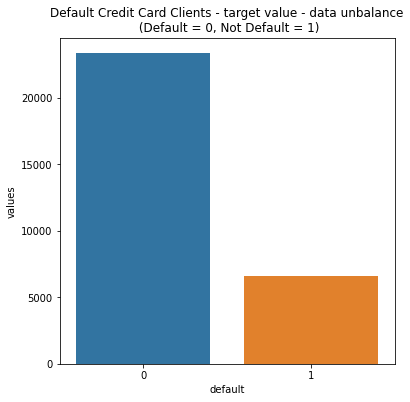

In [8]:
temp = dfo["default"].value_counts()
df = pd.DataFrame({'default': temp.index,'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Default Credit Card Clients - target value - data unbalance\n (Default = 0, Not Default = 1)')
sns.set_color_codes("pastel")
sns.barplot(x = 'default', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

Agora estamos verificando correlações. É uma parte importante do processo exploratório de análise de dados. Essa análise é um dos métodos usados para decidir quais recursos afetam mais a variável de destino e, por sua vez, são usados na previsão dessa variável de destino. Em outras palavras, é um método comumente usado para seleção de recursos no aprendizado de máquina.

As correlações são úteis porque podem indicar um relacionamento preditivo que pode ser explorado na prática. Veja o gráfico abaixo para ver todas as correlações entre os recursos. Existem fortes correlações entre pagamentos. Todos os outros são fragilidade.

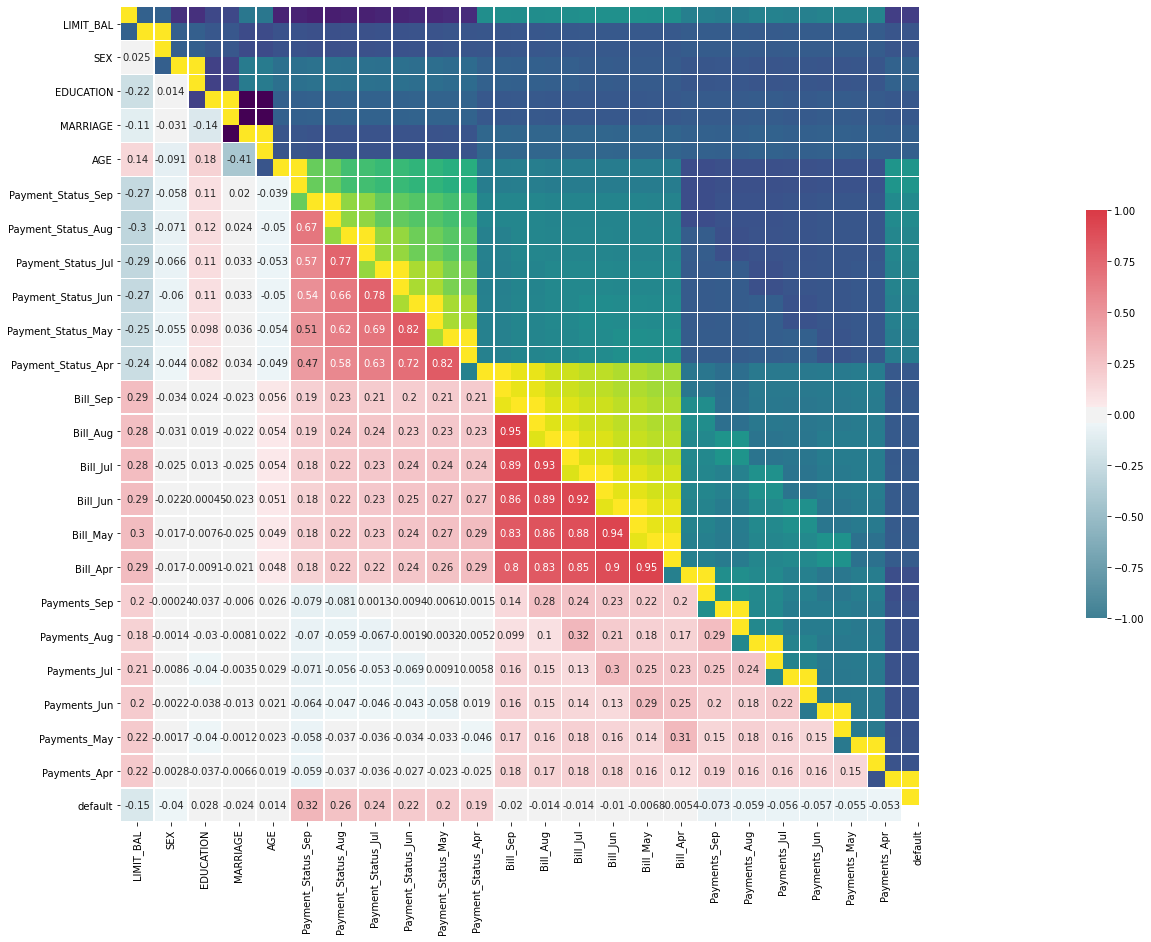

In [9]:
corr = dfo.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(54, 15))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1,center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.imshow(corr)

Podemos ver o mesmo fenômeno sobre o par abaixo. correlação fraca entre a maioria dos recursos, mas forte correlação entre contas e pagamentos.

* Para os valores numéricos, vamos representar a correlação de recursos.
* A correlação está diminuindo com a distância entre meses. As correlações mais baixas são entre setembro e abril.
* Não há correlações entre os valores dos pagamentos anteriores de abril a setembro de 2005.
* A correlação está diminuindo com a distância entre meses. As correlações mais baixas são entre setembro e abril.

**Veja abaixo**


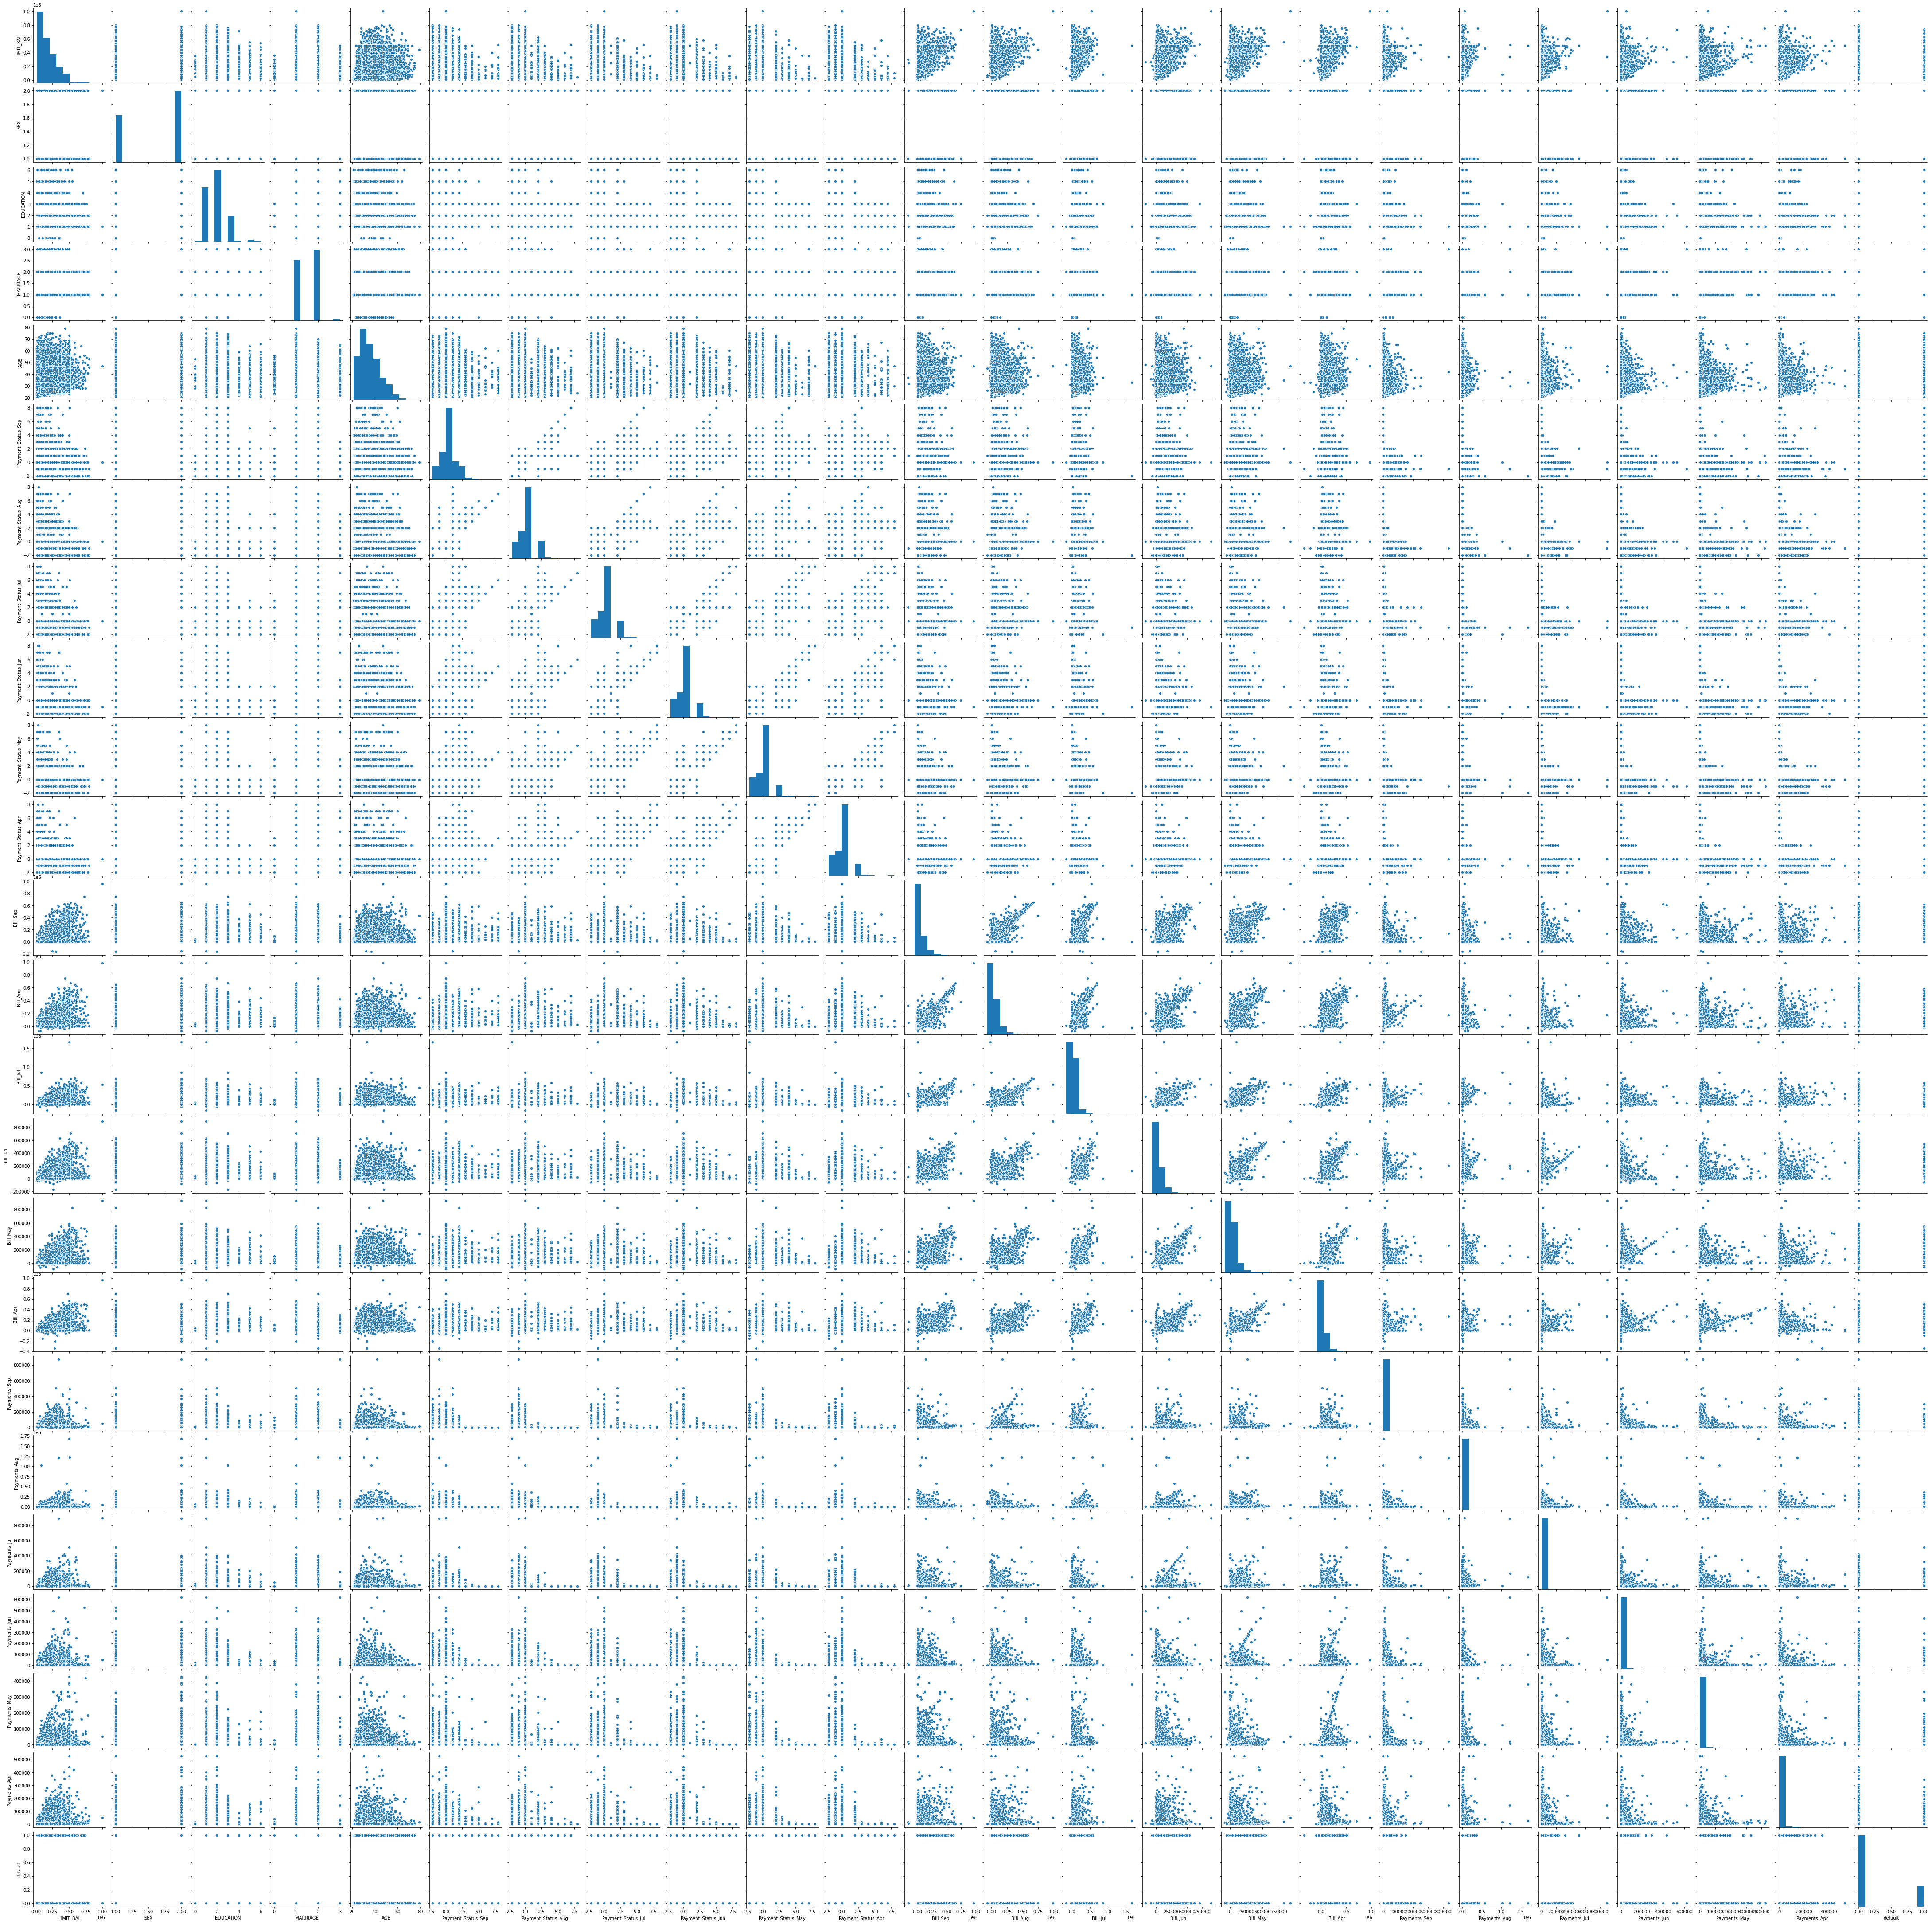

In [10]:
sns.pairplot(dfo)

### Valor do limite de crédito 

Vamos visualizar o gráfico de densidade para o valor do limite de crédito (LIMIT_BAL), agrupado por pagamento **default** no próximo mês.

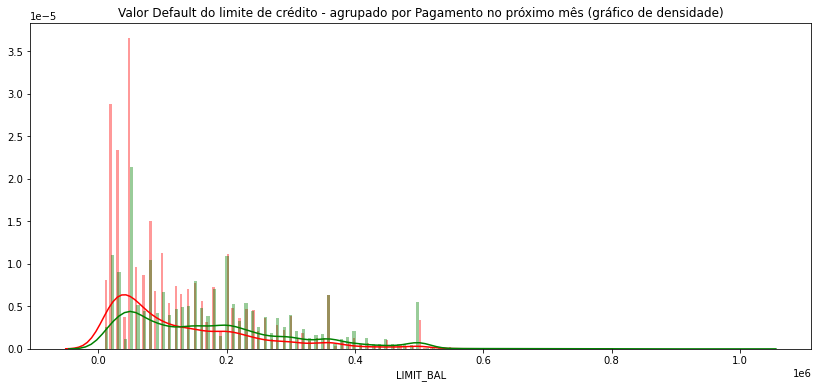

In [11]:
class_0 = dfo.loc[dfo['default'] == 0]["LIMIT_BAL"]
class_1 = dfo.loc[dfo['default'] == 1]["LIMIT_BAL"]
plt.figure(figsize = (14,6))
plt.title('Valor Default do limite de crédito - agrupado por Pagamento no próximo mês (gráfico de densidade)')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=200, color="red")
sns.distplot(class_0,kde=True,bins=200, color="green")
plt.show()

A maioria dos *default* é para limites de crédito de $0$ a $100.000$ (e a densidade desse intervalo é maior para *default* do que para não *default*). O número de *default* maiores corresponde aos valores de $50.000$, $20.000$ e $30.000$.


### Categorizando risco

1. Os IDs com pontuação acima de -2 mostram que os clientes sempre pagaram em dia.
2. Os IDs com valores positivos mostram o número de meses padrão de pagamento por cliente.
3. Os clientes devidamente pagos ao longo de um ano são bons clientes.

Categorizando o risco com base nos padrões de pagamento anteriores.

In [0]:
dfp = dfo.copy()
dfp['pay_total'] = (dfp.Payment_Status_Apr + dfp.Payment_Status_May + 
                    dfp.Payment_Status_Jun + dfp.Payment_Status_Jul + 
                    dfp.Payment_Status_Aug + dfp.Payment_Status_Sep)
dfp['risk_cat'] = pd.cut(dfp.pay_total, [-20,-10,0,3,10], labels=["low","medium","high","Very High"])

Feature 4: Categorias com base no uso: alto, médio, baixo.


In [13]:
dfp[['pay_total','risk_cat']].head(20)

pay_total   risk_cat
ID                      
1          -2     medium
2           3       high
3           0     medium
4           0     medium
5          -2     medium
6           0     medium
7           0     medium
8          -3     medium
9           2       high
10        -10        low
11          1       high
12         -3     medium
13         -5     medium
14          7  Very High
15          0     medium
16          3       high
17          8  Very High
18         -3     medium
19         -9     medium
20         -9     medium

Vejamos no gráfico abaixo que a inadimplência está sendo feita mais por faixa etária de 21 a 55 anos.

* Além da idade de 55 anos, o padrão de pagamentos cai drasticamente
* É o mais alto na faixa etária de 21 a 40 anos
* Indo além de 30 a 36 meses 

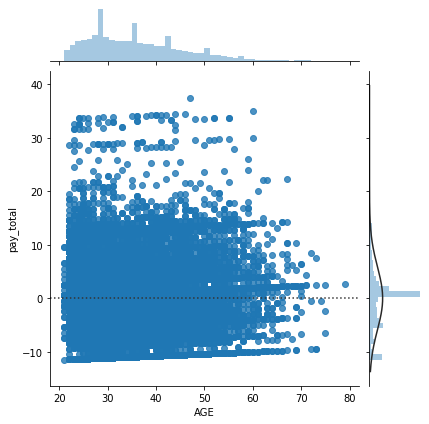

In [14]:
sns.jointplot("AGE", "pay_total", dfp, kind = 'resid')

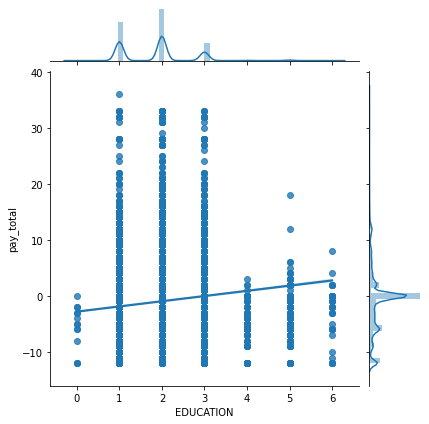

In [15]:
sns.jointplot('EDUCATION', 'pay_total', dfp, kind = 'regid')

# EDUCAÇÃO

1. Escola de Pós-Graduação
2. Universidade
3. Ensino médio
4. Outros
5. Desconhecido
6. Também desconhecido

Categoria de risco com base em sua educação

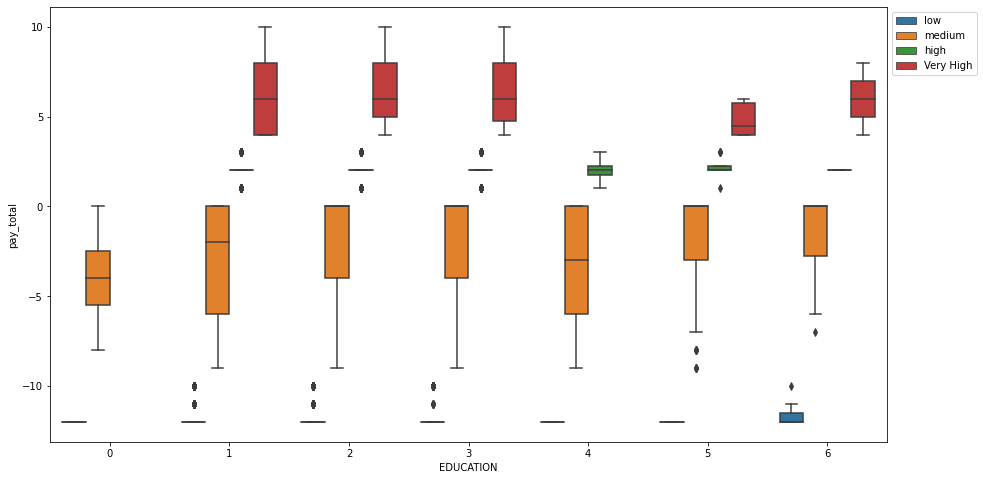

In [16]:
plt.figure(figsize=(15,8))
sns.boxplot(x= 'EDUCATION', y = 'pay_total',data=dfp, hue = 'risk_cat')
plt.legend(bbox_to_anchor=(1, 1), loc=2)

### Divisão de pessoas com base em sua categoria de risco

* Mais de 20 mil pessoas estão na categoria de risco médio
* Cerca de 6000 pessoas estão na categoria de alto risco
* Apenas 2500 pessoas estão na categoria de baixo risco
* Número total de pessoas 28544


In [17]:
dfp.risk_cat.count()

28544

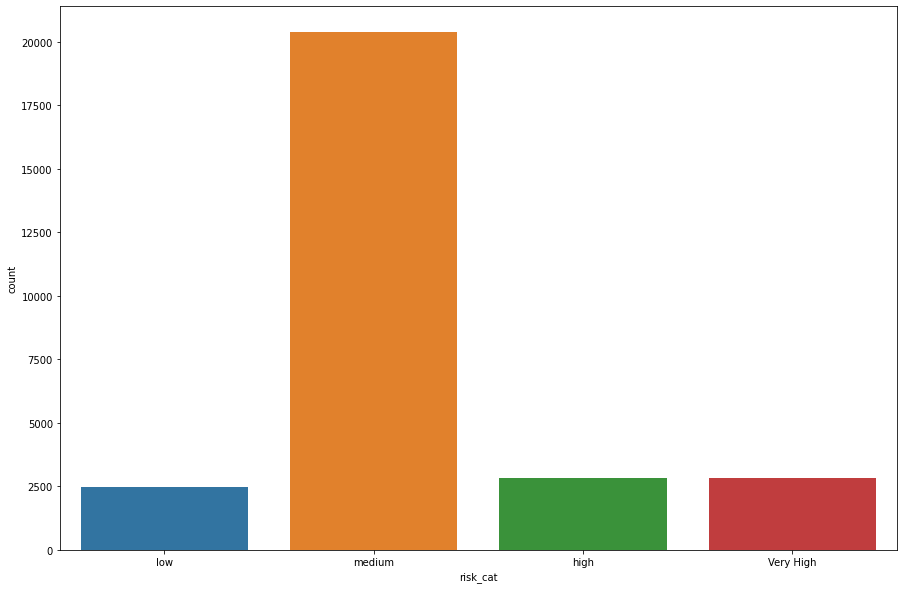

In [18]:
plt.figure(figsize = (15,10))
sns.countplot(x='risk_cat', data=dfp)

In [0]:
# deleting data frame that we not used any more
del dfp

## Outras estatísticas

### Procurando multicolinearidade

Em estatística, a multicolinearidade (também colinearidade) é um fenômeno em que uma variável preditora em um modelo de regressão múltipla pode ser prevista linearmente a partir de outras com um grau substancial de precisão. Nesta situação, as estimativas do coeficiente da regressão múltipla podem mudar erraticamente em resposta a pequenas mudanças no modelo ou nos dados. A multicolinearidade não reduz o poder preditivo ou a confiabilidade do modelo como um todo, pelo menos dentro do conjunto de dados de amostra; isso afeta apenas os cálculos referentes a preditores individuais. Ou seja, um modelo de regressão multivariado com preditores colineares pode indicar até que ponto todo o conjunto de preditores prediz a variável de resultado, mas pode não fornecer resultados válidos sobre qualquer preditor individual ou sobre quais preditores são redundantes em relação a outros.

Valores de VIF que excedem US $ 10 $ são frequentemente considerados indicadores de multicolinearidade, mas em modelos mais fracos, valores acima de US $ 2,5 $ podem ser motivo de preocupação.


In [0]:
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

y = dfo['default'] # dependent variable
X = dfo.drop('default', axis=1)

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [21]:
cols = dfo.columns
cols = cols[cols!='default']
pd.DataFrame(vif,cols,columns=['VIF'])

VIF
LIMIT_BAL            4.037479
SEX                  9.092210
EDUCATION            6.731119
MARRIAGE             6.265388
AGE                 10.857679
Payment_Status_Sep   1.918276
Payment_Status_Aug   3.211217
Payment_Status_Jul   3.727427
Payment_Status_Jun   4.440120
Payment_Status_May   4.985856
Payment_Status_Apr   3.463800
Bill_Sep            20.823400
Bill_Aug            38.214225
Bill_Jul            31.783029
Bill_Jun            29.548135
Bill_May            35.986369
Bill_Apr            21.426076
Payments_Sep         1.907500
Payments_Aug         2.384860
Payments_Jul         1.911689
Payments_Jun         1.805048
Payments_May         1.854229
Payments_Apr         1.270665

**Interpretação**

A raiz quadrada do fator de inflação da variância indica quanto maior o erro padrão aumenta em comparação com se essa variável teve correlação $0$ com outras variáveis preditivas no modelo.

Em nosso exemplo, o fator de inflação de variação de uma variável preditora foi de $ 6,731119 $ ($ √6,731119 = 2,5 $), isso significa que o erro padrão para o coeficiente dessa variável preditora é $ 2,5 $ vezes maior do que se essa variável preditora tivesse correlação de $ 0 $ com as outras variáveis preditoras.

Não vamos tirar essas variáveis do modelo, pois faremos a calibração para anular qualquer influência.

**Análise Residual**

A diferença entre o valor observado da variável dependente ($ y $) e o valor previsto ($ ŷ $) é chamado de residual ($ e $). Cada ponto de dados possui um residual.

Residual = Valor observado - Valor previsto $ e = y - ŷ $

A soma e a média dos resíduos são iguais a zero. Ou seja, $ Σ ** e = 0 $ e $ e = 0 $.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


0.11863331652675246

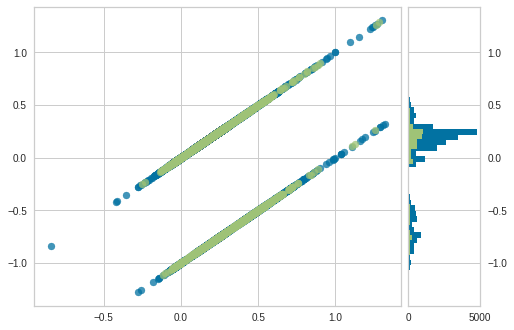

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Load a regression dataset
Y = dfo["default"]
X = dfo.drop(columns=['default'])

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Instantiate the linear model and visualizer
model = Ridge()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data

Os resíduos, no contexto dos modelos de regressão, são a diferença entre o valor observado da variável de destino ($ y $) e o valor previsto ($ ŷ $), ou seja, o erro da previsão. 

O gráfico de resíduos mostra a diferença entre os resíduos no eixo vertical e a variável dependente no eixo horizontal, permitindo detectar regiões no destino que podem ser suscetíveis a mais ou menos erros.

Um uso comum do gráfico de resíduos é analisar a variação do erro do regressor. Os pontos são dispersos aleatoriamente em torno do eixo horizontal; um modelo de regressão linear é geralmente apropriado para os dados; caso contrário, um modelo não linear é mais apropriado.

No caso acima, vemos uma distribuição uniforme e aleatória dos resíduos em relação ao alvo em duas dimensões. Isso parece indicar que nosso modelo linear está funcionando bem. Também podemos ver no histograma que nosso erro é normalmente distribuído em torno de $0,11$, o que geralmente também indica um modelo não está ajustado.

0.11462702213397125

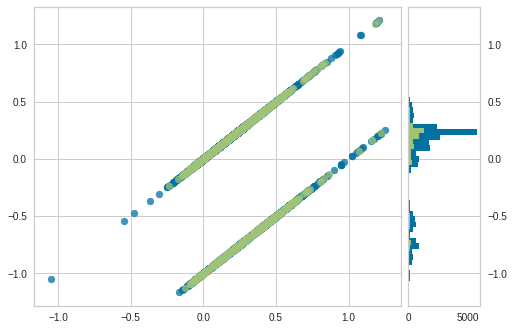

In [23]:
# Load a regression dataset
Y = dfo["default"]
X = dfo.drop(columns=['default','Bill_Apr','Bill_May','Bill_Jun','Bill_Jul','Bill_Aug','Bill_Sep','AGE','Payments_Jul','Payments_May'])

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Instantiate the linear model and visualizer
model = Ridge()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data

In [0]:
import statsmodels.formula.api as smf
cols = X.columns
formule = " + ".join(map(str, cols))
formule = "default ~ " + formule

In [25]:
reg = smf.ols(formule, data = dfo)
res = reg.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                default   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     286.9
Date:                Tue, 24 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:02:15   Log-Likelihood:                -14302.
No. Observations:               30000   AIC:                         2.863e+04
Df Residuals:                   29985   BIC:                         2.876e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3758      0

Isso significa que $11,8%$ da variância de $default$, é explicada pela variância de $X$


### Parsing

O parsing do Data Frame original para o modelo do *H2O* é necessário.

In [26]:
df = h2o.H2OFrame(dfo)

Parse progress: |█████████████████████████████████████████████████████████| 100%


Validando o novo Data Frame

In [27]:
df.head()

LIMIT_BAL SEX EDUCATION MARRIAGE AGE Payment_Status_Sep Payment_Status_Aug Payment_Status_Jul Payment_Status_Jun Payment_Status_May Payment_Status_Apr Bill_Sep Bill_Aug Bill_Jul Bill_Jun Bill_May Bill_Apr Payments_Sep Payments_Aug Payments_Jul Payments_Jun Payments_May Payments_Apr default 
 
 
 20000 2 2 1 24 2 2 -1 -1 -2 -2 3913 3102 689 0 0 0 0 689 0 0 0 0 1 
 120000 2 2 2 26 -1 2 0 0 0 2 2682 1725 2682 3272 3455 3261 0 1000 1000 1000 0 2000 1 
 90000 2 2 2 34 0 0 0 0 0 0 29239 14027 13559 14331 14948 15549 1518 1500 1000 1000 1000 5000 0 
 50000 2 2 1 37 0 0 0 0 0 0 46990 48233 49291 28314 28959 29547 2000 2019 1200 1100 1069 1000 0 
 50000 1 2 1 57 -1 0 -1 0 0 0 8617 5670 35835 20940 19146 19131 2000 36681 10000 9000 689 679 0 
 50000 1 1 2 37 0 0 0 0 0 0 64400 57069 57608 19394 19619 20024 2500 1815 657 1000 1000 800 0 
 500000 1 1 2 29 0 0 0 0 0 0 367965 412023 445007 542653 483003 473944 55000 40000 38000 20239 13750 13770 0 
 100000 2 2 2 23 0 -1 -1 0 0 -1 11876 380 601 221 -159 567 380 601 0 581 1687 1542 0 
 140000 2 3 1 28 0 0 2 0 0 0 11285 14096 12108 12211 11793 3719 3329 0 432 1000 1000 1000 0 
 20000 1 3 2 35 -2 -2 -2 -2 -1 -1 0 0 0 0 13007 13912 0 0 0 13007 1122 0 0

### Divida os dados em treinamento e teste

O conjunto de treinamento contém uma saída conhecida e o modelo aprende sobre esses dados para ser generalizado para outros dados posteriormente. 

Temos o conjunto de dados de teste (ou subconjunto) para testar a previsão do nosso modelo nesse subconjunto.

A variável *default* ou preditora deve ser uma variável do tipo *factor*. Fazemos a conversão aqui.

In [0]:
train, valid, test = df.split_frame(ratios=[0.7, 0.2], seed=1234)
test['default'] = test['default'].asfactor()
train['default'] = train['default'].asfactor()


### AutoML: Automatic Machine Learning

A interface do H2O AutoML foi projetada para ter o menor número possível de parâmetros, de modo que tudo que o usuário precisa é apontar para o conjunto de dados, identificar a coluna de resposta e, opcionalmente, especificar uma restrição de tempo ou limite no número total de modelos treinados.

Há outra biblioteca de AutoML. Escolhemos *H2O* por ser parte da **AWS Marketplace** que fornece uma maneira direta de implantar um cluster de VMs com H2O.

O Auto-sklearn fornece aprendizado de máquina supervisionado pronto para uso. Construído em torno da biblioteca de aprendizado de máquina do scikit-learn, o auto-sklearn pesquisa automaticamente o algoritmo de aprendizado correto para um novo conjunto de dados de aprendizado de máquina e otimiza seus hiperparâmetros. Assim, libera o praticante de aprendizado de máquina dessas tarefas tediosas e permite que ele se concentre no problema real.

[AUTO-SKLEARN](https://www.automl.org/automl/auto-sklearn/)

In [0]:
from h2o.automl import H2OAutoML, get_leaderboard
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1, include_algos = ["GLM", "DeepLearning", "DRF","xGBoost","StackedEnsemble"])

y = "default"
x = list(dfo.columns).remove(y)

In [30]:
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


### AutoML - Resultado

Os modelos são classificados por uma métrica padrão com base no tipo de problema (a segunda coluna do placar). Nos problemas de classificação binária, essa métrica é *AUC*, e nos problemas de classificação em várias classes, a métrica é o erro médio por classe. 

Em problemas de regressão, a métrica de classificação padrão é desvio.

In [31]:
lb = get_leaderboard(aml, extra_columns='ALL')
lb.head(rows=lb.nrows)

model_id auc logloss aucpr mean_per_class_error rmse mse training_time_ms predict_time_per_row_ms 
 
 
 StackedEnsemble_AllModels_AutoML_20200324_140222 0.788233 0.425574 0.563777 0.282094 0.364505 0.132864 17523 0.790383 
 StackedEnsemble_BestOfFamily_AutoML_20200324_140222 0.786646 0.426468 0.561937 0.281121 0.364948 0.133187 2533 0.071728 
 XGBoost_grid__1_AutoML_20200324_140222_model_2 0.786542 0.423947 0.558248 0.283418 0.364272 0.132694 10898 0.007396 
 XGBoost_3_AutoML_20200324_140222 0.78622 0.42349 0.560052 0.280969 0.363879 0.132408 5179 0.007382 
 XGBoost_grid__1_AutoML_20200324_140222_model_1 0.785129 0.424039 0.560778 0.28408 0.364091 0.132563 8738 0.007273 
 XGBoost_2_AutoML_20200324_140222 0.784994 0.424861 0.557623 0.284699 0.36466 0.132977 12392 0.015724 
 XGBoost_1_AutoML_20200324_140222 0.784022 0.425661 0.556171 0.283958 0.365153 0.133337 10529 0.013665 
 DRF_1_AutoML_20200324_140222 0.77282 0.434496 0.542449 0.294448 0.368687 0.13593 5140 0.030104 
 XRT_1_AutoML_20200324_140222 0.772745 0.433945 0.543098 0.292835 0.368662 0.135912 7066 0.030763 
 XGBoost_grid__1_AutoML_20200324_140222_model_3 0.770167 0.43888 0.54433 0.290904 0.370442 0.137227 7392 0.010075 
 DeepLearning_1_AutoML_20200324_140222 0.765024 0.438552 0.527592 0.301044 0.370177 0.137031 2601 0.00435 
 DeepLearning_grid__1_AutoML_20200324_140222_model_1 0.743553 0.461957 0.499217 0.307276 0.378151 0.142998 5022 0.043631 
 GLM_1_AutoML_20200324_140222 0.726291 0.462623 0.501751 0.311058 0.379575 0.144077 1220 0.001415 
 DeepLearning_grid__2_AutoML_20200324_140222_model_1 0.700175 1.03641 0.467052 0.330826 0.420712 0.176999 9939 0.622552

### O vencedor

O XGBoost é um algoritmo de aprendizado supervisionado que implementa um processo chamado impulso para gerar modelos precisos. Impulsionar refere-se à técnica de aprendizado por conjunto de construção de vários modelos sequencialmente, com cada novo modelo tentando corrigir as deficiências no modelo anterior. No aumento de árvore, cada novo modelo adicionado ao conjunto é uma árvore de decisão. O XGBoost fornece aumento de árvore paralelo (também conhecido como GBDT, GBM) que resolve muitos problemas de ciência de dados de maneira rápida e precisa. Para muitos problemas, o XGBoost é uma das melhores estruturas da máquina de aumento de gradiente (GBM) atualmente.

[Os modelos XGBoost dominam muitas competições do Kaggle.](https://www.kaggle.com/dansbecker/xgboost)

[Veja mais detalhes aqui](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/xgboost.html)

[AWS](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/cloud-integration/aws.html)

## Stacked Ensembles

[AWS H2O](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/stacked-ensembles.html?highlight=stackedensemble)

O **Stacking**, também chamado de **Super Learning** ou **Stacked Regression**, é uma classe de algoritmos que envolve o treinamento de um "aprendiz de metal" de segundo nível para encontrar a combinação ideal dos alunos de base. Ao contrário do ensacamento e do reforço, o objetivo do empilhamento é reunir conjuntos fortes e diversos de alunos.

[sklearn.ensemble.StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

Stacked generalization consiste em empilhar a saída do estimador individual e usar um classificador para calcular a previsão final. O empilhamento permite usar a força de cada estimador individual usando sua saída como entrada de um estimador final.



In [32]:
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
from __future__ import print_function
h2o.init()


# Identificar preditores e resposta
x = train.columns
y = "default"
x.remove(y)

# Para classificação binária, a resposta deve ser um factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Número de folds (para gerar dados de nível um para stacking)
nfolds = 5

# Existem algumas maneiras de montar uma lista de modelos para stacking:
# 1. Treine modelos individuais e coloque-os em uma lista
# 2. Treine uma grade de modelos
# 3. Treine várias grades de modelos <<=
# Nota: Todos os modelos de base devem ter as mesmos números de folds 
# de validação cruzada e os valores previstos de cross-validation 
# devem ser mantidos.


# 1. Gerando 2-model ensemble (GBM + RF)

# Train e cross-validate para um GBM
my_gbm = H2OGradientBoostingEstimator(distribution="bernoulli",
                                      ntrees=10,
                                      max_depth=3,
                                      min_rows=2,
                                      learn_rate=0.2,
                                      nfolds=nfolds,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1)
my_gbm.train(x=x, y=y, training_frame=train)


# Train e cross-validate para um RF
my_rf = H2ORandomForestEstimator(ntrees=50,
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 seed=1)
my_rf.train(x=x, y=y, training_frame=train)


# Train um stacked ensemble usando o GBM e  GLM abaixo
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial",
                                       base_models=[my_gbm, my_rf])
ensemble.train(x=x, y=y, training_frame=train)

# Avaliando o desempenho do conjunto nos dados de teste
perf_stack_test = ensemble.model_performance(test)

# Comparando com o desempenho básico do learner no conjunto de testes
perf_gbm_test = my_gbm.model_performance(test)
perf_rf_test = my_rf.model_performance(test)
baselearner_best_auc_test = max(perf_gbm_test.auc(), perf_rf_test.auc())
stack_auc_test = perf_stack_test.auc()
print("Best Base-learner Test AUC:  {0}".format(baselearner_best_auc_test))
print("Ensemble Test AUC:  {0}".format(stack_auc_test))

# 2. Gere uma grade aleatória de modelos e empilhando-os

# Specify GBM hyperparameters for the grid
hyper_params = {"learn_rate": [0.01, 0.03],
                "max_depth": [3, 4, 5, 6, 9],
                "sample_rate": [0.7, 0.8, 0.9, 1.0],
                "col_sample_rate": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}
search_criteria = {"strategy": "RandomDiscrete", "max_models": 3, "seed": 1}

# Train e grid
grid = H2OGridSearch(model=H2OGradientBoostingEstimator(ntrees=10,
                                                        seed=1,
                                                        nfolds=nfolds,
                                                        fold_assignment="Modulo",
                                                        keep_cross_validation_predictions=True),
                     hyper_params=hyper_params,
                     search_criteria=search_criteria,
                     grid_id="gbm_grid_binomial")
grid.train(x=x, y=y, training_frame=train)

# Train um stacked ensemble usando o GBM grid
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_gbm_grid_binomial",
                                       base_models=grid.model_ids)
ensemble.train(x=x, y=y, training_frame=train)

# Avaliando o desempenho do conjunto nos dados de teste
perf_stack_test = ensemble.model_performance(test)

# Comparando com o desempenho básico do learner no conjunto de testes
baselearner_best_auc_test = max([h2o.get_model(model).model_performance(test_data=test).auc() for model in grid.model_ids])
stack_auc_test = perf_stack_test.auc()
print("Best Base-learner Test AUC:  {0}".format(baselearner_best_auc_test))
print("Ensemble Test AUC:  {0}".format(stack_auc_test))


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ------------------------------------------------------------------
H2O cluster uptime:         16 mins 06 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.28.1.2
H2O cluster version age:    6 days
H2O cluster name:           H2O_from_python_unknownUser_45el1t
H2O cluster total nodes:    1
H2O cluster free memory:    2.865 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:       {'http': None, 'https': None}
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python version:             3.6.9 final
--------------------------  ------------------------------------------------------------------

gbm Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
stackedensemble Model Build progress: |███████████████████████████████████| 100%
Best Base-learner Test AUC:  0.7671059582917077
Ensemble Test AUC:  0.7716556749867924
stackedensemble prediction progress: |████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
stackedensemble Model Build progress: |███████████████████████████████████| 100%
Best Base-learner Test AUC:  0.7681591189630264
Ensemble Test AUC:  0.7705480566760059
stackedensemble prediction progress: |████████████████████████████████████| 100%


In [33]:
print("Best Base-learner Test F1:  {0}".format(perf_stack_test.F1().value))
print("Ensemble Test Accuracy   :  {0}".format(perf_stack_test.accuracy().value))
print("Ensemble Test AUCPR      :  {0}".format(perf_stack_test.aucpr()))

Best Base-learner Test F1:  0.5260576333537708
Ensemble Test Accuracy   :  0.8181223421655217
Ensemble Test AUCPR      :  0.5297396108679692


## Abordagem Tradicional

Vamos usar aqui o processamento manual para avaliar as diferenças.

### Balanceamento de Classes

O parâmetro **balance_classes=True** no código abaixo fornece suporte para a amostra que temos com classes desbalanceadas.

In [0]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

# função para configurar parâmetros para trabalhar com o modelo H2O xGBoost
def setDRFParam(ntrees=200,                   # número de árvores a serem construídas no modelo
                max_depth=20,                 # profundidade máxima em que cada árvore será construída
                balance_classes=True,         # pode ser usada para equilibrar a distribuição de classes
                sample_rate=0.75,             # usado para especificar a taxa de amostragem da linha (eixo x) (sem substituição)
                col_sample_rate_per_tree=0.8, # especifica a taxa de amostragem da coluna para cada árvore (sem substituição))
                min_rows=5,                   # número mínimo de observações para uma folha para dividir
                seed=3333,                    # random number generator (RNG)
                score_tree_interval=5,        # parada antecipada e tentativa de tornar a parada antecipada reproduzível
                calibrate_model=False,        # especificação da escala de Platt no DRF para probabilidades de classe calibradas
                categorical_encoding="one_hot_explicit", # esquema de codificação a ser usado para lidar com recursos categóricos
                distribution="bernoulli",     # no nosso caso, a coluna de resposta deve ser categórica de 2 classes
                fold_assignment="Stratified", # validação cruzada - é melhor para grandes conjuntos de dados = auto = random
                histogram_type="auto",        # é comumente usado para acelerar o processo de k-fold
                keep_cross_validation_predictions=True, # A validação cruzada N-fold é usada para validar um modelo internamente
                nfolds=5):
   
        param = {
              "ntrees" : ntrees                                      
            , "max_depth" : max_depth                                
            , "balance_classes" : balance_classes                    
            , "sample_rate" : sample_rate
            , "col_sample_rate_per_tree" : col_sample_rate_per_tree
            , "min_rows" : min_rows
            , "seed": seed
            , "score_tree_interval": score_tree_interval
            , "calibrate_model": calibrate_model
            , "categorical_encoding": categorical_encoding
            , "distribution": distribution
            , "fold_assignment": fold_assignment
            , "histogram_type": histogram_type
            , "nfolds": nfolds
        }
        return(param)

### Validação Cruzada

A validação cruzada é uma técnica para avaliar a capacidade de generalização de um modelo, a partir de um conjunto de dados. Esta técnica é amplamente empregada em problemas onde o objetivo da modelagem é a predição. 

O método de validação cruzada denominado $k-fold$ consiste em dividir o conjunto total de dados em k subconjuntos mutuamente exclusivos do mesmo tamanho e, a partir daí, um subconjunto é utilizado para teste e os $k-1$ restantes são utilizados para estimação dos parâmetros, fazendo-se o cálculo da acurácia do modelo. Este processo é realizado $k$ vezes alternando de forma circular o subconjunto de teste. 

Nesse experimento usamos $K$ com o valor de $5$, pois a quantidade de observações é pequena.

[Wikipédia](https://pt.wikipedia.org/wiki/Valida%C3%A7%C3%A3o_cruzada)

In [0]:
df['default'] = df['default'].asfactor()
train, valid = df.split_frame(ratios= [.7], seed = 1234)
response = 'default'
predictors = df.columns
histogram_type = 'auto'
categorical_encoding = 'auto'


### Numero de arvores

Alterando o parâmetro *ntrees* para $50$ e *max_depth* para $20$

Para algoritmos baseados em árvore, esta opção especifica o número de árvores a serem construídas no modelo. Nos modelos baseados em árvore, cada nó na árvore corresponde a um campo de recurso de um conjunto de dados. Exceto pelo nó superior, cada nó tem uma ramificação de entrada. Da mesma forma, exceto no nó inferior (ou nó folha), cada nó possui um número de ramificações de saída. Uma ramificação representa um valor possível para o campo de entrada do conjunto de dados de origem. Uma folha representa o valor do campo objetivo, dados todos os valores para cada campo de entrada na cadeia de ramificações que vão da raiz (superior) para essa folha.

In [36]:
param = setDRFParam(ntrees=50, max_depth=20,histogram_type=histogram_type,categorical_encoding=categorical_encoding)
model_xGBoost50 = H2OGradientBoostingEstimator(**param)
model_xGBoost50.train(x=predictors, y=response, training_frame=train,validation_frame = valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


Alterando o parâmetro *ntrees* para $200$ e *max_depth* para $40$

Podemos tentar muitas configurações usando um loop para muitos valores, começando em $50$ a $600$ para ver quais são os melhores resultados. 

Por enquanto, neste experimento, tentamos apenas dois.

In [37]:
param = setDRFParam(ntrees=200, max_depth=40,histogram_type=histogram_type,categorical_encoding=categorical_encoding)
model_xGBoost200 = H2OGradientBoostingEstimator(**param)
model_xGBoost200.train(x=predictors, y=response, training_frame=train, validation_frame = valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


### Salvando os modelos para ter acesso posterior

Ao salvar um modelo binário de H2O com *h2o.save_model* ou no Flow, você só poderá carregar e usar esse modelo binário salvo com a mesma versão do H2O usada para treinar seu modelo.

Isso é importante, pois se treinarmos vários modelos poderemos acessar interativamente esse modelos e analisar de forma comparativa, como veremos mais abaixo. 

Podemos inclusive criar históricos de modelos ao longo de sua evolução. 


In [0]:
import os

model_path = h2o.save_model(model=model_xGBoost50, path='.', force=True)
os.rename(model_path,os.path.split(model_path)[0]+'/xGBoost50')
model_path = h2o.save_model(model=model_xGBoost200, path='.', force=True)
os.rename(model_path,os.path.split(model_path)[0]+'/xGBoost200')


In [0]:
def showModel(modelImp,Var_Importance,Confusion_Matrix,Cross_Validation,Range):
    model = h2o.load_model(modelImp)
    if Confusion_Matrix:
        print(model.confusion_matrix())

    if Var_Importance:
        model.varimp_plot()
    else:
        varimpDF = model.varimp(True)
        print(varimpDF[varimpDF['scaled_importance'] >= Range])

    if Cross_Validation:
        print(model.cross_validation_metrics_summary())

In [0]:
models = ['xGBoost50','xGBoost200']

### Desempenho do Modelo

O H2O-3 fornece uma variedade de métricas que podem ser usadas para avaliar modelos supervisionados e não supervisionados. 

As métricas desta seção cobrem apenas modelos de aprendizado supervisionado, que variam com base no tipo de modelo (classificação ou regressão). No momento, mostramos apenas o desempenho da classificação, que é o nosso foco.



### Para o Modelo model_xGBoost50

A pontuação **F1** fornece uma medida de quão bem um classificador binário pode classificar casos positivos (dado um valor limite). A pontuação **F1** é calculada a partir da média harmônica da $precision$ e $recall$. Uma pontuação F1 de $1$ significa que precisão e recall são perfeitos, e o modelo identificou corretamente todos os casos positivos e não marcou um caso negativo como positivo. 

Se a precisão ou o recall forem muito baixos, isso será refletido com uma pontuação F1 mais próxima de 0.

* $Precision$ são as observações positivas (verdadeiros positivos) que o modelo identificou corretamente a partir de todas as observações que ele rotulou como positivas (os verdadeiros positivos + os falsos positivos).

* $Recall$ são as observações positivas (verdadeiros positivos) que o modelo identificou corretamente de todos os casos positivos reais (os verdadeiros positivos + os falsos negativos).


In [41]:
print('F1      : ', model_xGBoost50.F1(valid=True).value)
print('Accuracy: ', model_xGBoost50.accuracy(valid=True).value)


F1      :  0.5029570583697609
Accuracy:  0.8078047683310842


### AUC (Área sob a curva ROC)

Essa métrica do modelo é usada para avaliar quão bem um modelo de classificação binária é capaz de distinguir entre positivos verdadeiros e falsos positivos. 

Uma $AUC$ de $1$ indica um classificador perfeito, enquanto uma $AUC$ de $0,5$ indica um classificador ruim, cujo desempenho não é melhor do que suposições aleatórias. H2O usa a regra trapezoidal para aproximar a área sob a *ROC Curve*.


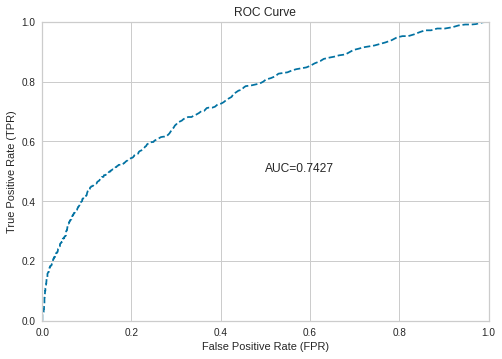

In [42]:
perf = model_xGBoost50.model_performance(test)
perf.plot(type = "roc")

H2O usa a regra trapezoidal para aproximar a área sob a curva ROC. (Dica: AUC geralmente não é a melhor métrica para um alvo binário desequilibrado (como o nosso caso), porque um número alto de Verdadeiros Negativos pode fazer com que a $AUC$ pareça inflada. Para um alvo binário desequilibrado, recomendamos $AUCPR$ ou $MCC$.)

In [43]:
# recuperação do AUCPR para o objeto de desempenho:
print("AUCPR : ", model_xGBoost50.aucpr(valid=True))

AUCPR :  0.517143919235997


In [44]:
# recuperação da AUCPR para os dados de treinamento e validação:
print("AUCPR :",model_xGBoost50.aucpr(valid=True))

AUCPR : 0.517143919235997


### Para o Modelo model_xGBoost200

In [45]:
print('F1      : ', model_xGBoost200.F1(valid=True).value)
print('Accuracy: ', model_xGBoost200.accuracy(valid=True).value)


F1      :  0.5107785949784428
Accuracy:  0.8112910481331534


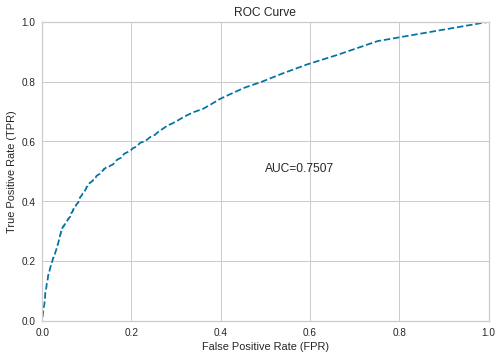

In [46]:
perf = model_xGBoost200.model_performance(valid)
perf.plot(type = "roc")

In [47]:
print("AUCPR: " ,model_xGBoost200.aucpr(valid=True))

AUCPR:  0.5071694709125107


In [48]:
print("AUCPR  :",model_xGBoost200.aucpr(valid=True))


AUCPR  : 0.5071694709125107


### Usando o Interact

A função de interação (ipywidgets.interact) cria automaticamente controles da interface do usuário (UI) para explorar códigos e dados de maneira interativa. É a maneira mais fácil de começar a usar os widgets do IPython.

In [49]:
interact(showModel,modelImp=models,Var_Importance=True,Confusion_Matrix=False,Cross_Validation=False,Range=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.1))

interactive(children=(Dropdown(description='modelImp', options=('xGBoost50', 'xGBoost200'), value='xGBoost50')…

<function __main__.showModel>

## Outra abordagem

### Support Vector Machines (SVM)

Outra abordagem possível é o SVM. As máquinas de vetores de suporte (SVMs) são um conjunto de métodos de aprendizado supervisionado usados ​​para classificação, regressão e detecção de outliers.

As vantagens das máquinas de vetores de suporte:

* Ainda eficaz nos casos em que o número de dimensões é maior que o número de amostras
* Utiliza um subconjunto de pontos de treinamento na função de decisão (denominada vetores de suporte), portanto, também é eficiente em termos de memória
* Versátil: diferentes funções do Kernel podem ser especificadas para a função de decisão. Kernels comuns são fornecidos, mas também é possível especificar kernels personalizados.

As desvantagens das máquinas de vetores de suporte incluem:

* Se o número de recursos for muito maior que o número de amostras, evite o ajuste excessivo na escolha das funções do Kernel e o termo de regularização é crucial.

* Os SVMs não fornecem diretamente estimativas de probabilidade, elas são calculadas usando uma validação cruzada de cinco vezes.

**Por que estamos fazemos isso?**

Para ver como esse algoritmo funciona em comparação com o que fizemos até agora.

In [50]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# Obtendo dados de destino
y = dfo['default']

# Load X Variables em um dataframe do Pandas com colunas 
X = dfo.drop(['default'], axis = 1)

SVM_Model = SVC(gamma='auto')
SVM_Model.fit(X,y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Model Performance

Para o Modelo SVM 


In [51]:
print(f'Accuracy -  : {SVM_Model.score(X,y):.6f}')

Accuracy -  : 0.993133


In [0]:
yhat_probs = SVM_Model.predict(X)


In [53]:
f1 = f1_score(y, yhat_probs)
print('SVM F1 score: %f' % f1)

SVM F1 score: 0.984308


In [54]:
accuracy = accuracy_score(y, yhat_probs)
print('Accuracy: %f' % accuracy)

Accuracy: 0.993133


In [55]:
auc = roc_auc_score(y, yhat_probs)
print('SVM ROC AUC: %f' % auc)

SVM ROC AUC: 0.986151


In [78]:
from sklearn.metrics import classification_report

print(classification_report(yhat_probs,y, labels=[0,1]))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     23508
           1       0.97      1.00      0.98      6492

    accuracy                           0.99     30000
   macro avg       0.99      0.99      0.99     30000
weighted avg       0.99      0.99      0.99     30000



Sem um balanceamento das classes, estamos avaliando mal pagadores como bons.

## Avaliando o modelo Generalized Linear Estimator

Essa é uma flexível generalização da regressão de mínimos quadrados ordinária.

In [56]:
linear_Model = H2OGeneralizedLinearEstimator(family = 'binomial', 
                                             max_iterations = 50,
                                             nfolds=5,
                                             keep_cross_validation_predictions=True,
                                             fold_assignment="Stratified")
linear_Model.train(x = predictors, y = response, training_frame = train, validation_frame = valid)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [57]:
print('F1      : ', linear_Model.F1(valid=True).value)
print('Accuracy: ', linear_Model.accuracy(valid=True).value)
print('AUCPR   : ', linear_Model.aucpr(valid=True))


F1      :  0.5029177718832891
Accuracy:  0.8138776428250113
AUCPR   :  0.5007723883745349


In [58]:
linear_Model.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2897507535810691: 


0       1   Error               Rate
0      0  14738.0  1718.0  0.1044   (1718.0/16456.0)
1      1   2413.0  2239.0  0.5187    (2413.0/4652.0)
2  Total  17151.0  3957.0  0.1957   (4131.0/21108.0)

### Conclusão

Podemos concluir, com os dados abaixo:

**Modelo Stacked Ensembles**

* Best Base-learner Test F1:  0.5260576333537708
* Ensemble Test Accuracy   :  0.8181223421655217
* Ensemble Test AUCPR      :  0.5297396108679692

**Modelo xGBoost com 50 árvores**
* F1...........:  0.5029570583697609
* Accuracy:  0.8078047683310842
* AUCPR...:  0.517143919235997

**Modelo xGBoost com 200 árvores**
* F1...........: 0.5107785949784428
* Accuracy: 0.8112910481331534
* AUCPR....: 0.5071694709125107

**Modelo SVM**
* SVM F1 score: 0.984308
* Accuracy........: 0.993133
* SVM ROC AUC: 0.986151

**Modelo GLM**
* F1...........:  0.5029177718832891
* Accuracy:  0.8138776428250113
* AUCPR....:  0.5007723883745349

O modelo gerado pelo SVM foi mais performático que os demais, porém uma avaliação de *Precision* e *Recall* e *Support* observa-se que houve *overfitting*.

É possível prever, com boa acurácia bons e maus pagadores.

Todo o exercício analisa o desempenho de vários algoritmos para calcular o risco de uma pessoa estar inadimplente no pagamento com cartão de crédito. O desempenho dos algoritmos é medido usando várias métricas. A detecção de fraudes no cartão de crédito (padrão) é um problema complicado em termos de perspectiva dos negócios. Para capturar o máximo de inadimplentes (True Positives) e minimizar (False Positives) sem prejudicar os sentimentos dos clientes. A seleção de modelos baseada apenas na precisão não faz muito sentido, porque o conjunto de dados é desequilibrado e inclinado. Portanto, a sensibilidade ou recuperação (True Positive Rate), juntamente com a precisão do modelo, são importantes. Highrecall significa que mais infratores são capturados. E precisão razoavelmente alta significa menos falsos positivos. Um bom modelo é um equilíbrio entre alta recuperação e alta precisão razoável. Portanto, a F-Measure e a curva ROC são as métricas que estamos procurando, juntamente com a Precision and Recall.

O trabalho futuro deste projeto pode incluir o uso de redes neurais, além de metodologias alternativas de mineração de dados para verificar se a verdadeira taxa positiva para prever os inadimplentes está aumentando juntamente com a precisão do modelo. Também poderíamos aplicar a combinação de idades para segmentar os clientes de acordo com a faixa etária. Isso certamente pode nos ajudar a descobrir que quais podem ser as características distintivas de uma pessoa que foi classificada como inadimplente. Isso pode ajudar os bancos a tomar decisões informadas, por exemplo, o que todos os recursos precisam ser incluídos em uma pessoa para emitir um cartão de crédito ou julgar a elegibilidade ou capacidade de reembolso de uma pessoa.